In [1]:
from helper import *
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

In [2]:
fo = pd.ExcelFile('dataclean.xlsx')
df = pd.read_excel(fo, 'Sheet1')

text = df['text']
text_list =  [i.split() for i in text]
print(len(text_list))

2082


In [3]:
#Create Bigram & Trigram Models 
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(text_list, min_count=10)
trigram = Phrases(bigram[text_list], min_count=10)

for idx in range(len(text_list)):
    for token in bigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)
    for token in trigram[text_list[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            text_list[idx].append(token)

In [4]:
from gensim import corpora, models
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(text_list)
dictionary.filter_extremes(no_below=5, no_above=0.2)
print(dictionary)

Dictionary(1662 unique tokens: ['appears', 'area', 'beta', 'boston', 'called']...)


In [5]:
#build corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]

print(len(doc_term_matrix))
print(doc_term_matrix[100])

tfidf = models.TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix]

2082
[(146, 1), (159, 1), (508, 1), (594, 1), (596, 1), (633, 1), (634, 1), (635, 1), (636, 1)]


In [6]:
from gensim.models.coherencemodel import CoherenceModel
# from gensim.models.ldamodel import LdaModel
# from gensim.models.hdpmodel import HdpModel
from gensim.models import LdaModel, HdpModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
#function to compute coherence values
def compute_coherence_values_lda(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

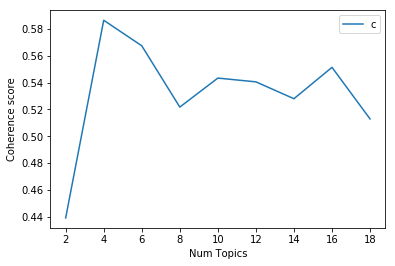

In [8]:
# LDA
start=2 # sama dengan k=2
limit=20 # jadi mksdnya sama dengan from 2 until 18
step=2 # kelipatannya hingga mencapai limit 20
model_list, coherence_values = compute_coherence_values_lda(dictionary, corpus=corpus_tfidf, 
                                                        texts=text_list, start=start, limit=limit, step=step)

#show graphs
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [9]:
# Print the coherence scores for LDA
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4391
Num Topics = 4  has Coherence Value of 0.5864
Num Topics = 6  has Coherence Value of 0.5674
Num Topics = 8  has Coherence Value of 0.5217
Num Topics = 10  has Coherence Value of 0.5433
Num Topics = 12  has Coherence Value of 0.5405
Num Topics = 14  has Coherence Value of 0.5279
Num Topics = 16  has Coherence Value of 0.5513
Num Topics = 18  has Coherence Value of 0.5129


In [10]:
from pprint import pprint
#LDA
model_lda = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=4)
pprint(model_lda.print_topics())

[(0,
  '0.016*"saturday" + 0.015*"quit" + 0.013*"people" + 0.013*"many" + '
  '0.009*"baghdad" + 0.007*"source" + 0.007*"iraqis" + 0.007*"northern" + '
  '0.007*"wants" + 0.007*"forces"'),
 (1,
  '0.019*"united_states" + 0.011*"ended" + 0.010*"york_reuters" + '
  '0.010*"talks" + 0.010*"climate" + 0.009*"pakistani" + 0.009*"reuters" + '
  '0.008*"year" + 0.008*"stay" + 0.008*"global"'),
 (2,
  '0.014*"giants" + 0.010*"reuters" + 0.008*"said_friday" + '
  '0.008*"toronto_raptors" + 0.008*"finally" + 0.007*"chicago" + '
  '0.006*"saturday" + 0.006*"said" + 0.006*"sports_network" + 0.006*"stores"'),
 (3,
  '0.008*"prime_minister" + 0.008*"chittagong" + 0.007*"second" + '
  '0.007*"northern" + 0.007*"saturday" + 0.007*"flows" + 0.006*"turkey" + '
  '0.006*"taiwan" + 0.006*"port" + 0.006*"victims"')]


In [11]:
#HDP
model_hdp = HdpModel(corpus=corpus_tfidf, id2word=dictionary)
pprint(model_hdp.print_topics(num_topics=4))

[(0,
  '0.005*released + 0.004*spokeswoman + 0.004*suspected + 0.004*withdrawn + '
  '0.004*miss + 0.004*sprint + 0.003*find + 0.003*billion + 0.003*special + '
  '0.003*united_states'),
 (1,
  '0.005*russia + 0.005*consortium + 0.005*equipment + 0.004*terrorist + '
  '0.004*appeared + 0.004*planned + 0.004*flight + 0.003*coach + 0.003*record '
  '+ 0.003*times'),
 (2,
  '0.004*tech + 0.004*currency + 0.004*celtics + 0.003*continuing + '
  '0.003*closed + 0.003*unbeaten + 0.003*overseer + 0.003*could + 0.003*ties + '
  '0.003*afternoon'),
 (3,
  '0.005*billions + 0.004*rose + 0.004*across + 0.004*music + 0.003*paul + '
  '0.003*national + 0.003*billion + 0.003*abused + 0.003*introduced + '
  '0.003*according')]


In [12]:
model_lda = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=4)

for idx, topic in model_lda.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))
    
ldatopics = model_lda.show_topics(formatted=False)

Topic: 0 Word: 0.019*"giants" + 0.011*"toronto_raptors" + 0.010*"north" + 0.009*"fast" + 0.009*"climate" + 0.009*"saturday" + 0.008*"syria" + 0.008*"time" + 0.008*"vince_carter" + 0.007*"pressure"
Topic: 1 Word: 0.012*"chittagong" + 0.008*"test" + 0.008*"bangladesh" + 0.008*"news" + 0.008*"million" + 0.007*"said" + 0.007*"open" + 0.007*"saturday" + 0.007*"taiwan" + 0.006*"fourth_quarter"
Topic: 2 Word: 0.013*"united_states" + 0.011*"quit" + 0.009*"reuters" + 0.008*"chicago" + 0.007*"pakistani" + 0.006*"steps" + 0.006*"stores" + 0.006*"year" + 0.006*"wants" + 0.006*"early"
Topic: 3 Word: 0.013*"prime_minister" + 0.012*"people" + 0.011*"bosnian_serb" + 0.011*"northern" + 0.011*"saturday" + 0.010*"finally" + 0.009*"left" + 0.009*"many" + 0.008*"flows" + 0.007*"baghdad"


In [13]:
model_hdp = HdpModel(corpus=corpus_tfidf, id2word=dictionary)

for idx, topic in model_hdp.print_topics(num_topics = 4):
    print('Topic: {} Word: {}'.format(idx, topic))
    
hdptopics = model_hdp.show_topics(formatted=False)

Topic: 0 Word: 0.004*manager + 0.004*managed + 0.004*plan + 0.004*aaron + 0.004*elections + 0.003*acquiring + 0.003*found + 0.003*massive + 0.003*coming + 0.003*hours
Topic: 1 Word: 0.004*press + 0.004*james + 0.004*british + 0.004*headquarters + 0.004*clear + 0.004*standing + 0.004*financing + 0.004*family + 0.003*presidential + 0.003*taiwan
Topic: 2 Word: 0.005*poured + 0.005*doctor + 0.004*space + 0.004*amsterdam + 0.004*built + 0.004*quote + 0.004*among + 0.003*foot + 0.003*explorer + 0.003*lawyer
Topic: 3 Word: 0.004*reserve + 0.004*developing + 0.004*competition + 0.004*giants + 0.004*mariners + 0.004*library + 0.004*hussein + 0.003*block + 0.003*calls + 0.003*relief


In [14]:
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

lda_coherence = CoherenceModel(topics=ldatopics, texts=text_list, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics, texts=text_list, dictionary=dictionary, window_size=10).get_coherence()

In [15]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

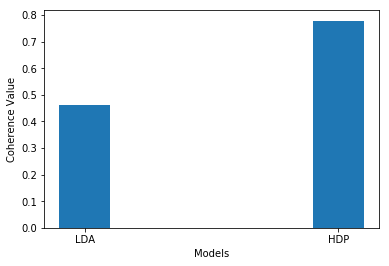

In [16]:
evaluate_bar_graph([lda_coherence, hdp_coherence], ['LDA', 'HDP'])

In [17]:
import pandas as pd
top_words_per_topic = []
for t in range(model_lda.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in model_lda.show_topic(t, topn = 10)])

#pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")
df = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word','P']).to_csv("top_words2.csv")
print(df)

None


In [18]:
import gensim
import pyLDAvis.gensim;pyLDAvis.enable_notebook()

data = pyLDAvis.gensim.prepare(model_lda, corpus_tfidf, dictionary)
print(data)
pyLDAvis.save_html(data, 'lda-gensim-40.html')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.147386  0.017369       1        1  27.610409
2      0.093327 -0.061255       2        1  27.492737
0     -0.004330 -0.091107       3        1  23.090042
3      0.058389  0.134993       4        1  21.806814, topic_info=     Category       Freq             Term      Total  loglift  logprob
term                                                                  
1003  Default  28.000000           giants  28.000000  30.0000  30.0000
559   Default  17.000000  toronto_raptors  17.000000  29.0000  29.0000
1315  Default  21.000000       chittagong  21.000000  28.0000  28.0000
1629  Default  17.000000     bosnian_serb  17.000000  27.0000  27.0000
713   Default  21.000000   prime_minister  21.000000  26.0000  26.0000
1250  Default  14.000000          finally  14.000000  25.0000  25.0000
466   Default  21.000000         northern  21.000000  24.0000  24

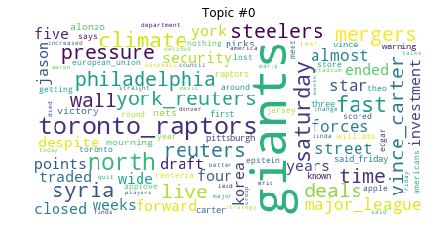

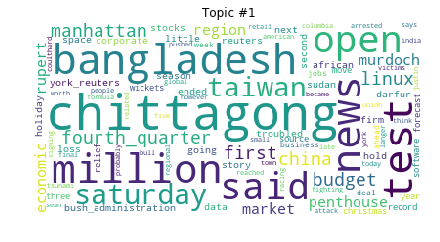

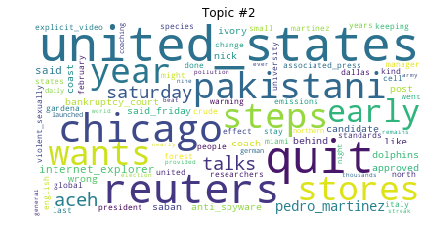

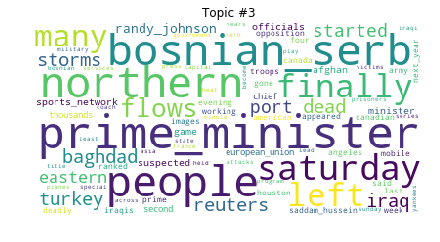

In [19]:
# Word Cloud LDA
import matplotlib.pyplot as plt
from wordcloud import WordCloud as wd

for t in range (model_lda.num_topics):
    plt.figure(figsize=(7,6))
    plt.imshow(wd(max_font_size=50, min_font_size=6, background_color="white").fit_words(dict(model_lda.show_topic(t,200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.savefig("wcld-topic-#"+str(t)+".png", facecolor='k', bbox_inches='tight')
    
    plt.show()

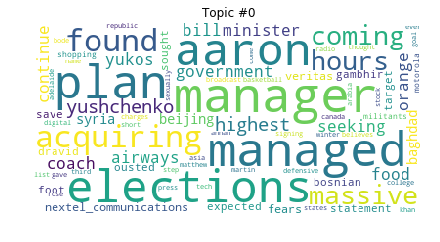

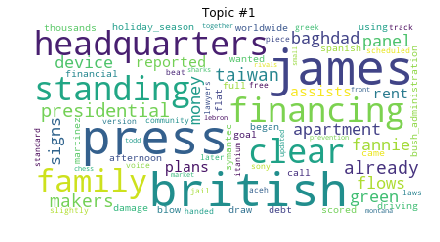

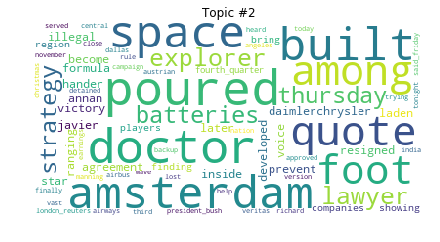

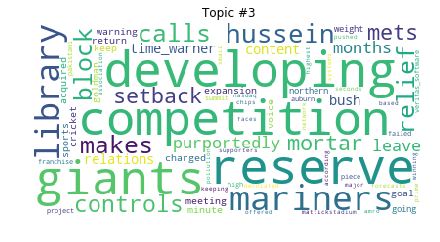

In [20]:
# Word Cloud HDP
for t in range (len(model_hdp.print_topics(num_topics=4))):
    plt.figure(figsize=(7,6))
    plt.imshow(wd(max_font_size=50, min_font_size=6, background_color="white").fit_words(dict(model_hdp.show_topic(t,200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.savefig("wcld-topic-#"+str(t)+".png", facecolor='k', bbox_inches='tight')
    
    plt.show()